## Build a riverine SFINCS model from scratch

This notebook demonstrates how to prepare **SFINCS** model from scratch using the command line interace (CLI).

All lines in this notebook which start with `!` are executed from the command line. Within the notebook environment the logging messages are shown after completion. You can also copy these lines and paste these in your shell to get more direct feedback.

### hydroMT CLI build interface

Lets first check if the SFINCS model is recognized by hydromt

In [1]:
# this should return "sfincs"
!hydromt --models

hydroMT model plugins: sfincs (v0.2.1.dev0)


Using the **hydromt build** API we can setup a complete model from scratch. Let's get an overview of all the available options:

In [2]:
!hydromt build --help

Usage: hydromt build [OPTIONS] MODEL MODEL_ROOT REGION

  Build models from source data.

  Example usage:
  --------------

  To build a wflow model for a subbasin using and point coordinates snapped to cells with stream order >= 4
  hydromt build wflow /path/to/model_root "{'subbasin': [-7.24, 62.09], 'strord': 4}" -i /path/to/wflow_config.ini

  To build a wflow model based on basin ID
  hydromt build wflow /path/to/model_root "{'basin': 230001006}"

  To build a sfincs model based on a bbox (for Texel)
  hydromt build sfincs /path/to/model_root "{'bbox': [4.6891,52.9750,4.9576,53.1994]}"

Options:
  -r, --res FLOAT             Model resolution in model src.
  --build-base / --build-all  Deprecated!
  --opt TEXT                  Component specific keyword arguments, see the
                              setup_<component> method of the specific model
                              for more information about the arguments.
  -i, --config PATH           Path to hydroMT configuration fil

### setup SFINCS model base layers 

In [3]:
# NOTE: copy this line (without !) to your shell for more direct feedback
!hydromt build sfincs "./sfincs_test_base" "{'bbox': [11.97,45.78,12.28,45.94]}" -r 100 -vv

2022-01-31 08:36:09,935 - build - log - DEBUG - Writing log messages to new file /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/sfincs_test_base/hydromt.log.
2022-01-31 08:36:09,935 - build - log - INFO - HydroMT version: 0.4.5.dev
2022-01-31 08:36:09,935 - build - main - INFO - Building instance of sfincs model at /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/sfincs_test_base.
2022-01-31 08:36:09,935 - build - main - INFO - User settings:
2022-01-31 08:36:09,938 - build - model_plugins - DEBUG - Loaded model plugin 'sfincs = hydromt_sfincs.sfincs.SfincsModel' (0.2.1.dev0)
2022-01-31 08:36:09,938 - build - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v0.2.1.dev0).
2022-01-31 08:36:09,939 - build - model_api - WARNING - "res" argument ignored as the "setup_topobathy" is not in the model build configuration.
2022-01-31 08:36:09,939 - build - model_api - INFO - setup_region.region: {'bbox': [11.97, 45.78, 12.28, 45.94]}
2022-01-31 08:3

The example above means the following: run **hydromt build** with:

* `sfincs` : i.e. build a sfincs model
* `./sfincs_test_base` : output model folder
* `"{'bbox': [11.97,45.78,12.28,45.94]}"` : make a model that is active for the full given bounding box. All *REGION* options are described in the [docs](https://deltares.github.io/hydromt/latest/user_guide/cli.html#region-options)
* `-r 100` : build the model at a 100 meter resolution
* `-vv` : give some extra verbosity (2 * v) to display feedback on screen. Now debug messages are provided.

NOTE: As we did not specify a model configuration, only the model region has been prepared. To build a complete model we need the use a configuraton ini-file.

### Model setup configuration

The ini-file contains the model setup configuration and determines which components are build and in which order and optionally sets non-default arguments for each component. This configuration is passed to hydromt using `-i <path_to_ini_file>`. We have prepared several example ini-files which are available in the model repository [examples folder](https://github.com/Deltares/hydromt_sfincs/tree/main/examples) and from the [docs(build_configuration)](https://deltares.github.io/hydromt_sfincs/latest/user_guide/sfincs/build_configuration.html). 

Each header as shown between `[...]` (e.g. `[setup_topobathy]`) corresponds to a model component. All model components are explained in the [docs(model_components)](https://deltares.github.io/hydromt_sfincs/latest/user_guide/sfincs/components.html). 

We will load the default SFINCS build ini file for inspection:

In [4]:
fn_ini = "sfincs_riverine.ini"
with open(fn_ini, "r") as f:
    txt = f.read()
print(txt)

[setup_config]
tref = 20210101 000000
tstart = 20210101 000000
tstop = 20210102 000000
alpha = 0.5
zsini = 0.0
dtmaxout = 86400

[setup_region]                  # method to determine (hydrological) model region
hydrography_fn = merit_hydro
basin_index_fn = merit_hydro_index

[setup_topobathy]
topobathy_fn = merit_hydro       # topobathy basemaps ['elevtn']

[setup_river_hydrography]       # required for setup_river_bathymetry & used by setup_river_inflow & setup_river_outflow if no hydrography_fn passed to those methods
hydrography_fn = merit_hydro    # hydrography maps ['flwdir', 'uparea']

[setup_river_bathymetry]
river_geom_fn = data/rivers_lin2019_v1.geojson  # river geometry with columns ['qbankfull', 'rivwth']
river_upa = 25                   # Mimimum upstream area threshold of rivers [km2]
river_len = 1000                 # minimum length inside river domain [m] 
rivdph_method=gvf                # gradual varying flow method
rivwth_method=geom               # with based on valu

### Data for model setup

The `<...>_fn` arguments correspond to a data source from the `DataCatalog` which is based on a yml-file with references to the data paths/urls and how the data should be read. This file can be provided to hydromt using `-d <path_to_yml_file>`. 

By default some example data for the Piave basin will be downloaded to `$USER_ROOT$/.hydromt_data/` which is also used for this example. An overview of the available example data is provided [here](https://deltares.github.io/hydromt/latest/user_guide/data.html#available-global-datasets)
This example data is a based on the data which available from the Deltares p-drive. 
If you have acces to this drive, a pre-configured catalog file can be loaded using the `--dd` flag. 

More background how to write a data catalog yml file can be found in the [hydromt core docs](https://deltares.github.io/hydromt/latest/user_guide/data.html) 

### Setup complete SFINCS model 

In [5]:
# NOTE: copy this line (without !) to your shell for more direct feedback
!hydromt build sfincs "./sfincs_test_full" "{'bbox': [11.97,45.78,12.28,45.94]}" -r 50 -i sfincs_riverine.ini -vv

2022-01-31 08:36:12,511 - build - log - DEBUG - Writing log messages to new file /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/sfincs_test_full/hydromt.log.
2022-01-31 08:36:12,511 - build - log - INFO - HydroMT version: 0.4.5.dev
2022-01-31 08:36:12,511 - build - main - INFO - Building instance of sfincs model at /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/sfincs_test_full.
2022-01-31 08:36:12,511 - build - main - INFO - User settings:
2022-01-31 08:36:12,516 - build - model_plugins - DEBUG - Loaded model plugin 'sfincs = hydromt_sfincs.sfincs.SfincsModel' (0.2.1.dev0)
2022-01-31 08:36:12,517 - build - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v0.2.1.dev0).
2022-01-31 08:36:12,517 - build - model_api - DEBUG - Setting model config options.
2022-01-31 08:36:12,518 - build - model_api - DEBUG - Default config read from /usr/share/miniconda/envs/hydromt-sfincs/lib/python3.9/site-packages/hydromt_sfincs/data/sfincs/sfincs.inp
202

2022-01-31 08:36:12,609 - build - data_adapter - INFO - Adding sample data v0.0.6 from artifacts


2022-01-31 08:36:12,676 - build - data_adapter - INFO - DataCatalog: Getting merit_hydro RasterDataset raster data from /home/runner/.hydromt_data/data/v0.0.6/merit_hydro/{variable}.tif


2022-01-31 08:36:12,697 - build - data_adapter - DEBUG - RasterDataset: Clip with geom - [11.961, 45.772, 12.288, 45.948]


2022-01-31 08:36:12,752 - build - model_api - INFO - setup_river_hydrography.hydrography_fn: merit_hydro
2022-01-31 08:36:12,753 - build - model_api - INFO - setup_river_hydrography.adjust_dem: False
2022-01-31 08:36:12,753 - build - data_adapter - INFO - DataCatalog: Getting merit_hydro RasterDataset raster data from /home/runner/.hydromt_data/data/v0.0.6/merit_hydro/{variable}.tif


2022-01-31 08:36:12,820 - build - data_adapter - DEBUG - RasterDataset: Clip with geom - [11.970, 45.780, 12.280, 45.940]


2022-01-31 08:36:12,836 - build - sfincs - INFO - Reprojecting hydrography data to destination grid.


2022-01-31 08:36:15,211 - build - flw - INFO - Deriving flow direction from reprojected synthethic elevation.


2022-01-31 08:36:21,446 - build - flw - INFO - Calculating upstream area with 5 river inflows.


2022-01-31 08:36:21,791 - build - flw - DEBUG - New/org max upstream area: 3938.01/3956.60 km2
2022-01-31 08:36:21,803 - build - sfincs - INFO - Saving hydrography data to staticmaps.
2022-01-31 08:36:21,806 - build - model_api - INFO - setup_river_bathymetry.river_geom_fn: /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/data/rivers_lin2019_v1.geojson
2022-01-31 08:36:21,806 - build - model_api - INFO - setup_river_bathymetry.river_mask_fn: None
2022-01-31 08:36:21,806 - build - model_api - INFO - setup_river_bathymetry.qbankfull_fn: None
2022-01-31 08:36:21,806 - build - model_api - INFO - setup_river_bathymetry.rivdph_method: gvf
2022-01-31 08:36:21,806 - build - model_api - INFO - setup_river_bathymetry.rivwth_method: geom
2022-01-31 08:36:21,806 - build - model_api - INFO - setup_river_bathymetry.river_upa: 25
2022-01-31 08:36:21,806 - build - model_api - INFO - setup_river_bathymetry.river_len: 1000
2022-01-31 08:36:21,806 - build - model_api - INFO - setup_river_ba

2022-01-31 08:36:21,868 - build - data_adapter - WARNING - Overwriting data source rivers_lin2019_v1.
2022-01-31 08:36:21,869 - build - data_adapter - INFO - DataCatalog: Getting rivers_lin2019_v1 GeoDataFrame vector data from /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/data/rivers_lin2019_v1.geojson
2022-01-31 08:36:21,870 - build - data_adapter - INFO - GeoDataFrame: Read vector data and clip to geom (epsg:4326) [11.970, 45.780, 12.280, 45.940].


2022-01-31 08:36:25,379 - build - bathymetry - INFO - Deriving bankfull river surface elevation profile.


2022-01-31 08:36:34,020 - build - bathymetry - DEBUG - Burn bedlevel values into DEM.
2022-01-31 08:36:34,031 - build - bathymetry - DEBUG - Interpolate bedlevel values


2022-01-31 08:36:35,173 - build - bathymetry - DEBUG - Correct for D4 connectivity bed level


2022-01-31 08:36:36,517 - build - model_api - INFO - setup_river_inflow.hydrography_fn: None
2022-01-31 08:36:36,518 - build - model_api - INFO - setup_river_inflow.river_upa: 25
2022-01-31 08:36:36,518 - build - model_api - INFO - setup_river_inflow.river_len: 1000
2022-01-31 08:36:36,518 - build - model_api - INFO - setup_river_inflow.keep_rivers_geom: False
2022-01-31 08:36:36,518 - build - model_api - INFO - setup_river_inflow.buffer: 10


2022-01-31 08:36:36,760 - build - flwdir - DEBUG - 3 river inflow point locations found.
2022-01-31 08:36:36,776 - build - sfincs - DEBUG - discharge forcing: setting src data for 3 points.
2022-01-31 08:36:36,776 - build - sfincs - DEBUG - discharge forcing: setting dis data.
2022-01-31 08:36:36,776 - build - model_api - INFO - setup_river_outflow.hydrography_fn: None
2022-01-31 08:36:36,777 - build - model_api - INFO - setup_river_outflow.river_upa: 10
2022-01-31 08:36:36,777 - build - model_api - INFO - setup_river_outflow.river_len: 1000
2022-01-31 08:36:36,777 - build - model_api - INFO - setup_river_outflow.outflow_width: 2500
2022-01-31 08:36:36,777 - build - model_api - INFO - setup_river_outflow.append_bounds: False
2022-01-31 08:36:36,777 - build - model_api - INFO - setup_river_outflow.keep_rivers_geom: False


2022-01-31 08:36:37,023 - build - flwdir - DEBUG - 6 river outflow point locations found.


2022-01-31 08:36:37,190 - build - sfincs - DEBUG - 307 outflow (mask=3) boundary cells set.
2022-01-31 08:36:37,191 - build - model_api - INFO - setup_cn_infiltration.cn_fn: gcn250
2022-01-31 08:36:37,191 - build - model_api - INFO - setup_cn_infiltration.antecedent_runoff_conditions: avg
2022-01-31 08:36:37,191 - build - data_adapter - INFO - DataCatalog: Getting gcn250 RasterDataset raster data from /home/runner/.hydromt_data/data/v0.0.6/gcn250/{variable}.tif
2022-01-31 08:36:37,200 - build - data_adapter - DEBUG - RasterDataset: Clip with geom - [11.970, 45.780, 12.280, 45.940]
2022-01-31 08:36:37,230 - build - sfincs - INFO - Updating CN map based on "rivmsk" from setup_river_hydrography method.


2022-01-31 08:36:37,247 - build - model_api - INFO - setup_manning_roughness.lulc_fn: vito
2022-01-31 08:36:37,247 - build - model_api - INFO - setup_manning_roughness.map_fn: None
2022-01-31 08:36:37,247 - build - model_api - INFO - setup_manning_roughness.riv_man: 0.03
2022-01-31 08:36:37,247 - build - model_api - INFO - setup_manning_roughness.lnd_man: 0.1
2022-01-31 08:36:37,250 - build - data_adapter - INFO - DataCatalog: Getting vito RasterDataset raster data from /home/runner/.hydromt_data/data/v0.0.6/vito.tif
2022-01-31 08:36:37,258 - build - data_adapter - DEBUG - RasterDataset: Clip with geom - [11.970, 45.780, 12.280, 45.940]
2022-01-31 08:36:37,279 - build - landuse - INFO - Deriving N using average resampling (nodata=-999.0).


2022-01-31 08:36:37,324 - build - sfincs - INFO - Setting constant manning roughness for river cells.
2022-01-31 08:36:37,333 - build - model_api - INFO - setup_gauges.gauges_fn: /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/data/riverine_gauges.csv
2022-01-31 08:36:37,333 - build - model_api - INFO - setup_gauges.overwrite: False
2022-01-31 08:36:37,333 - build - data_adapter - INFO - DataCatalog: Getting riverine_gauges GeoDataFrame csv data from /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/data/riverine_gauges.csv
2022-01-31 08:36:37,334 - build - data_adapter - INFO - GeoDataFrame: Read csv data and clip to geom (epsg:4326) [11.970, 45.780, 12.280, 45.940].


2022-01-31 08:36:37,344 - build - sfincs - INFO - obs set based on /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/data/riverine_gauges.csv
2022-01-31 08:36:37,344 - build - model_api - INFO - setup_q_forcing.geodataset_fn: None
2022-01-31 08:36:37,344 - build - model_api - INFO - setup_q_forcing.timeseries_fn: /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/data/discharge_input_sfincs.csv
2022-01-31 08:36:37,358 - build - sfincs - DEBUG - discharge forcing: setting src data for 3 points.
2022-01-31 08:36:37,358 - build - sfincs - DEBUG - discharge forcing: setting dis data.
2022-01-31 08:36:37,359 - build - model_api - WARNING - Replacing forcing: dis
2022-01-31 08:36:37,359 - build - sfincs - INFO - Writing model data to /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/sfincs_test_full


2022-01-31 08:36:37,405 - build - sfincs - DEBUG - Write binary map indices based on mask.


2022-01-31 08:36:37,447 - build - sfincs - DEBUG - Write binary map files: ['dep', 'msk', 'scs', 'manning'].


2022-01-31 08:36:37,584 - build - sfincs - INFO - Write raster file(s) for staticmaps to 'gis' subfolder


2022-01-31 08:36:37,968 - build - sfincs - INFO - Write staticgeom files
2022-01-31 08:36:37,970 - build - sfincs - INFO - Write vector file(s) for staticgeoms to 'gis' subfolder
2022-01-31 08:36:37,997 - build - sfincs - INFO - Write forcing files


2022-01-31 08:36:38,004 - build - sfincs - INFO - Write vector file(s) for forcing.dis to 'gis' subfolder
2022-01-31 08:36:38,014 - build - model_api - INFO - Writing model config to /home/runner/work/hydromt_sfincs/hydromt_sfincs/docs/_examples/sfincs_test_full/sfincs.inp


With this example we build a complete SFINCS model including forcing. Compared to the previous **hydromt build** we have added:
* `-i sfincs_riverine.ini` : setup configuration file including all components to build and their arguments

Next we check which files have been created. The model root should contain two netcdf (.nc) files, one for the staticmaps and one for the forcing data, a SFINCS configuration (sfincs.inp) file. These files are sufficient to run the SFINCS model. In addition several geometry (.geojson) files are saved in the *staticgeoms* folder.  Finally, the setup process is logged in the hydromt.log file. 

In [6]:
import os

root = "sfincs_test_full"
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        print(f" - {name}")

sfincs_test_full
 - sfincs.dep
 - sfincs.ind
 - sfincs.msk
 - hydromt.log
 - sfincs.obs
 - sfincs.scs
 - sfincs.man
 - sfincs.dis
 - sfincs.src
 - hydromt_data.yml
 - sfincs.inp
sfincs_test_full/gis
 - dep.tif
 - uparea.tif
 - flwdir.tif
 - rivmsk.tif
 - msk.tif
 - rivers.geojson
 - region.geojson
 - scs.tif
 - obs.geojson
 - manning.tif
 - src.geojson


### Visualize and/or inspect model schematization

### Inspecting the model
Let's have a closer look at the model. To interact with a model within a notebook or python script, we need to load a number of modules.

In [7]:
%matplotlib inline
from hydromt_sfincs import SfincsModel
import os

Now we can load the model in memory and inspect it.
Shown is the elevation in the SFINCS model as map, the main rivers as blue lines that determine the inflow locations, the minor rivers in red lines that determine the outflow locations and discharge input points as numbered triangles.

In [8]:
# define the model's configuration file
root = r"./sfincs_test_full"
# read the model with hydromt sfincs methods
mod = SfincsModel(root=root, mode="r")
mod.read()

/usr/share/miniconda/envs/hydromt-sfincs/lib/python3.9/site-packages/hydromt_sfincs/plots.py:221: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_msk = gpd.overlay(


(<Figure size 1008x655.2 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'SFINCS dep map'}, xlabel='x coordinate UTM zone 33N [m]', ylabel='y coordinate UTM zone 33N [m]'>)

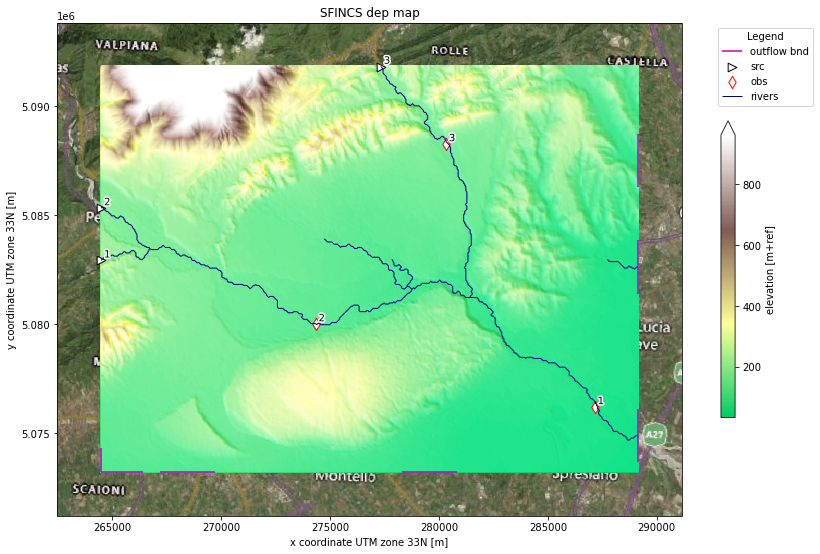

In [9]:
mod.plot_basemap(
    geoms=["src", "obs", "rivers"],
    figsize=(14, 14 * 0.65),
)

(<Figure size 432x216 with 1 Axes>,
 [<AxesSubplot:title={'center':'SFINCS discharge forcing (dis)'}, ylabel='discharge\n[m3.s-1]'>])

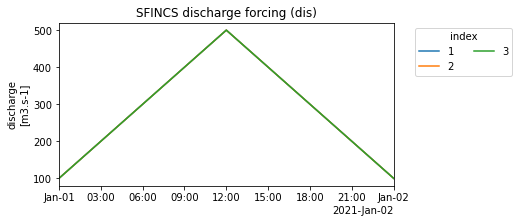

In [10]:
mod.plot_forcing()